This notebook is aimed at identifying unphased regions of the priamry contigs based on short read illumina mapping data. Parts of it are really slow.


This notebook was only designed for the purpose of analyzing the Pst-104E genome and now was adapted to the DK09-11 genome. No gurantees it works in any other situtation. It will have spelling errors due to the lack of autocorrection.

### Coverage analysis script
The original idea of the script is to simply use the coverage dataframe generated by 
samtools depth -aa ${x} > ${x}.aa.cov and pull out 1x homozygous and unique coverage areas. This is fr now done with the 'DK_0911_v03_p_ctg.bwamem.PRI_NTKN_DK0911.sam.sorted.bam.aa.cov' files.
Think about use DeepTools in future when comparing mulitple mapping experiments.

#### preserved comments and ideas from the origianl version
do a groupby and the mean on this. get ride of the high coverage contigs. calcutate standard statistics. Do a rolling window on each group and convert to a gff file kind of format.
also look at the coverage on p only and calcualte coverage there in the same way this should be the diploid coverage really (kind off). 
Think about combining the two dataframes for pcontigs and do a covariation analysis on the sliding windows look for areas where there is no change for p vs ph mapping and high coverage in both cases. This should be a homozygous region.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn
import matplotlib
from Bio import SeqIO, SeqUtils
import os

In [3]:
#Define the PATH
BASE_AA_PATH = '/home/benjamin/genome_assembly/Warrior'
BASE_A_PATH = '/home/benjamin/genome_assembly/Warrior/genome_v04'
#for now use the previous mapping that still included high coverage regions
COV_IN_PATH = '/home/benjamin/genome_assembly/Warrior/SRM'
BAM_IN_PATH = '/home/benjamin/genome_assembly/Warrior/SRM'
#apply analysis restricted to final assembly Pst_104E_v12
COV_OUT_PATH = os.path.join(BASE_AA_PATH, 'COV')
if not os.path.isdir(COV_OUT_PATH):
    os.mkdir(COV_OUT_PATH)
pwh_list_path = os.path.join(BASE_A_PATH, 'DK_0911_v04_pwh.list')
pwoh_list_path = os.path.join(BASE_A_PATH, 'DK_0911_v04_pwoh.list')

In [4]:
input_genome = 'DK0911_v03'
coverage_file_suffix = 'bwamem.PRI_NTKN_DK0911.sam.sorted.bam.aa.cov'
output_genome = 'DK0911_v04'

In [5]:
#get all the cov files with this coverage_file_suffix. Expacts to get all three p, h and ph mapping
cov_files = [os.path.join(COV_IN_PATH, x) for x in os.listdir(COV_IN_PATH) if x.endswith(coverage_file_suffix)]

In [6]:
cov_header = ["contig", "position", 'coverage']

In [7]:
ph_cov = pd.read_csv([y for y in cov_files if 'ph_ctg' in y][0], sep='\t', header=None, names=cov_header)
print('Read in following file as ph_coverage produced with samtools depth -aa feature: %s' %[y for y in cov_files if 'ph_ctg' in y][0])

Read in following file as ph_coverage produced with samtools depth -aa feature: /home/benjamin/genome_assembly/Warrior/SRM/DK_0911_v03_ph_ctg.bwamem.PRI_NTKN_DK0911.sam.sorted.bam.aa.cov


In [8]:
p_cov = pd.read_csv([y for y in cov_files if 'p_ctg' in y][0], sep='\t', header=None, names=cov_header)
print('Read in following file as p_coverage produced with samtools depth -aa feature: %s' %[y for y in cov_files if 'p_ctg' in y][0])

Read in following file as p_coverage produced with samtools depth -aa feature: /home/benjamin/genome_assembly/Warrior/SRM/DK_0911_v03_p_ctg.bwamem.PRI_NTKN_DK0911.sam.sorted.bam.aa.cov


In [9]:
h_cov = pd.read_csv([y for y in cov_files if '_h_ctg' in y][0], sep='\t', header=None, names=cov_header)
print('Read in following file as h_coverage produced with samtools depth -aa feature: %s' %[y for y in cov_files if '_h_ctg' in y][0])

Read in following file as h_coverage produced with samtools depth -aa feature: /home/benjamin/genome_assembly/Warrior/SRM/DK_0911_v03_h_ctg.bwamem.PRI_NTKN_DK0911.sam.sorted.bam.aa.cov


The mean overall coverage is 29.61 and the std is 95.38 for p


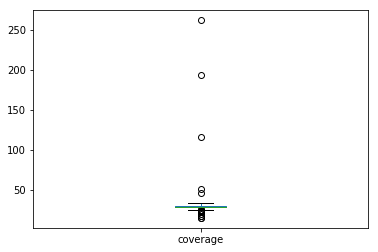

In [10]:
#summarize the mean coverage by contigs for p_contigs when mapping against p_contigs only
mean_cov_per_contig = p_cov.groupby('contig').mean()

mean_cov_per_contig['coverage'].plot.box()

overall_mean = p_cov['coverage'].mean()

overall_std = p_cov['coverage'].std()

print("The mean overall coverage is %.2f and the std is %.2f for p" % (overall_mean, overall_std))

The mean overall coverage is 17.75 and the std is 77.68 for ph mapping


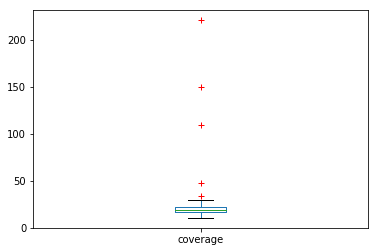

In [11]:
#summarize the mean coverage by contigs for all contigs when mapping against p and h contigs. Plot only coverage plot for p_contigs
mean_cov_per_contig_ph = ph_cov.groupby('contig').mean()
mean_cov_per_contig_ph['contig'] = mean_cov_per_contig_ph.index
mean_cov_per_contig_ph[mean_cov_per_contig_ph['contig'].str.contains('pcontig')]['coverage'].plot.box(sym ='r+')
overall_mean_ph = ph_cov['coverage'].mean()

overall_std_ph = ph_cov['coverage'].std()

print("The mean overall coverage is %.2f and the std is %.2f for ph mapping" % (overall_mean_ph, overall_std_ph))

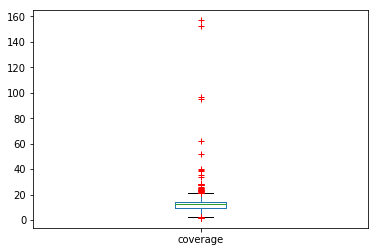

In [12]:
mean_cov_per_contig_ph[mean_cov_per_contig_ph['contig'].str.contains('hcontig')]['coverage'].plot.box(sym ='r+')

The mean overall coverage is 32.41 and the std is 103.89 for ph mapping


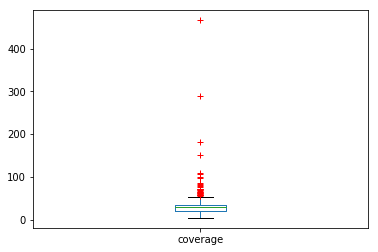

In [13]:
#summarize the mean coverage by contigs for h contigs when mapping against h contigs. Plot only coverage plot for h_contigs
mean_cov_per_contig_h = h_cov.groupby('contig').mean()
mean_cov_per_contig_h['contig'] = mean_cov_per_contig_h.index
mean_cov_per_contig_h['coverage'].plot.box(sym ='r+')

overall_mean_h = h_cov['coverage'].mean()

overall_std_h = h_cov['coverage'].std()

print("The mean overall coverage is %.2f and the std is %.2f for ph mapping" % (overall_mean_h, overall_std_h))

In [14]:
mean_cov_per_contig.columns

Index(['position', 'coverage'], dtype='object')

In [15]:
#these are the primary contigs with a coverage greater than 50
pcongtig_greater_50 = list(mean_cov_per_contig[mean_cov_per_contig.coverage > 50 ].index.unique())

In [16]:
pcongtig_greater_50

['pcontig_052', 'pcontig_101', 'pcontig_105', 'pcontig_106']

In [17]:
congtig_ph_greater_50 = list(mean_cov_per_contig_ph[mean_cov_per_contig_ph.coverage > 50 ].index.unique())

In [18]:
congtig_ph_greater_50

['hcontig_000_012',
 'hcontig_000_061',
 'hcontig_015_022',
 'hcontig_035_016',
 'hcontig_101_001',
 'hcontig_106_001',
 'pcontig_052',
 'pcontig_101',
 'pcontig_106']

Look at contigs 52, 101, and 106 if this is something particular

In [19]:
hcongtig_greater_50 = list(mean_cov_per_contig_h[mean_cov_per_contig_h.coverage > 50 ].index.unique())

In [20]:
hcongtig_greater_50

['hcontig_000_012',
 'hcontig_000_041',
 'hcontig_000_061',
 'hcontig_000_076',
 'hcontig_001_020',
 'hcontig_001_033',
 'hcontig_001_036',
 'hcontig_003_026',
 'hcontig_004_011',
 'hcontig_006_008',
 'hcontig_008_025',
 'hcontig_010_012',
 'hcontig_010_015',
 'hcontig_011_034',
 'hcontig_012_011',
 'hcontig_015_022',
 'hcontig_016_015',
 'hcontig_016_020',
 'hcontig_018_006',
 'hcontig_018_011',
 'hcontig_020_024',
 'hcontig_021_021',
 'hcontig_022_009',
 'hcontig_026_016',
 'hcontig_033_002',
 'hcontig_035_008',
 'hcontig_035_016',
 'hcontig_040_004',
 'hcontig_049_009',
 'hcontig_054_006',
 'hcontig_067_002',
 'hcontig_067_005',
 'hcontig_069_004',
 'hcontig_076_004',
 'hcontig_083_001',
 'hcontig_089_001',
 'hcontig_095_002',
 'hcontig_101_001',
 'hcontig_106_001']

In [21]:
{x[:-4] for x in hcongtig_greater_50}

{'hcontig_000',
 'hcontig_001',
 'hcontig_003',
 'hcontig_004',
 'hcontig_006',
 'hcontig_008',
 'hcontig_010',
 'hcontig_011',
 'hcontig_012',
 'hcontig_015',
 'hcontig_016',
 'hcontig_018',
 'hcontig_020',
 'hcontig_021',
 'hcontig_022',
 'hcontig_026',
 'hcontig_033',
 'hcontig_035',
 'hcontig_040',
 'hcontig_049',
 'hcontig_054',
 'hcontig_067',
 'hcontig_069',
 'hcontig_076',
 'hcontig_083',
 'hcontig_089',
 'hcontig_095',
 'hcontig_101',
 'hcontig_106'}

In [22]:
#get a ph coverage dataframe that does not included the pcontigs greater 50x coverage
ph_cov_smaller_50 = ph_cov[~ph_cov['contig'].isin(pcongtig_greater_50)]

In [23]:
#claculate the mean contig coverage
mean_cov_ph_contig_smaller_50 = ph_cov_smaller_50.groupby('contig').mean()

In [24]:
#fix this up by removing hcontigs associated with pcontigs that have greater 50x coverage
mean_cov_ph_contig_smaller_50 = mean_cov_ph_contig_smaller_50[~mean_cov_ph_contig_smaller_50.index.str[:-4].isin(\
                              [x.replace('pc', 'hc') for x in pcongtig_greater_50])]

In [25]:
#get the list of p contigs with haplotig [pwh] and without haplotig [pwoh]
pwh_list = pd.read_csv(pwh_list_path, sep='\t', header=None)[0].tolist()
pwoh_list = pd.read_csv(pwoh_list_path, sep='\t', header=None)[0].tolist()

The mean overall coverage for s50 contigs of pwh contigs while ph mapping is 19.28 and the std is 3.91


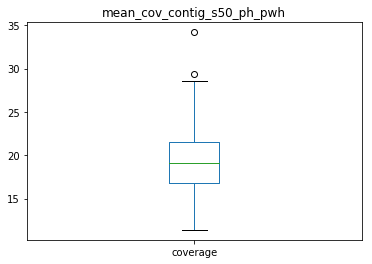

In [26]:
#mean_cov_contig_s2000_ph_pwh represents all contigs that are below 2000x coverage and are pwh contigs
mean_cov_ph_contig_smaller_50_pwh = mean_cov_ph_contig_smaller_50[mean_cov_ph_contig_smaller_50.index.isin(pwh_list)]
mean_cov_ph_contig_smaller_50_pwh['coverage'].plot.box()
plt.title('mean_cov_contig_s50_ph_pwh')
mean_s50_ph_pwh = mean_cov_ph_contig_smaller_50_pwh['coverage'].mean()
std_s50_ph_pwh = mean_cov_ph_contig_smaller_50_pwh['coverage'].std()
print("The mean overall coverage for s50 contigs of pwh contigs while ph mapping is %.2f and the std is %.2f" % (mean_s50_ph_pwh, std_s50_ph_pwh))

The mean overall coverage for s50 contigs of pwoh contigs while ph mapping is 16.94 and the std is 6.86


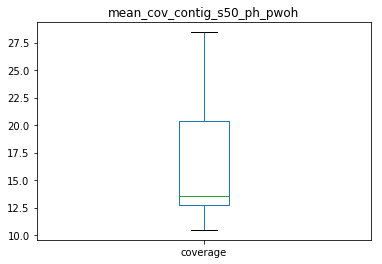

In [27]:
#mean_cov_contig_s2000_ph_pwh represents all contigs that are below 2000x coverage and are pwh contigs
mean_cov_ph_contig_smaller_50_pwoh = mean_cov_ph_contig_smaller_50[mean_cov_ph_contig_smaller_50.index.isin(pwoh_list)]
mean_cov_ph_contig_smaller_50_pwoh['coverage'].plot.box()
plt.title('mean_cov_contig_s50_ph_pwoh')
mean_s50_ph_pwoh = mean_cov_ph_contig_smaller_50_pwoh['coverage'].mean()
std_s50_ph_pwoh = mean_cov_ph_contig_smaller_50_pwoh['coverage'].std()
print("The mean overall coverage for s50 contigs of pwoh contigs while ph mapping is %.2f and the std is %.2f" % (mean_s50_ph_pwoh, std_s50_ph_pwoh))

The mean overall coverage for s50 contigs of h contigs while ph mapping is 12.36 and the std is 6.63


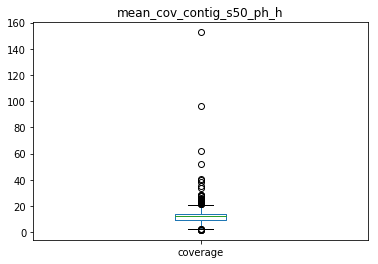

In [28]:
#mean_cov_contig_s2000_ph_pwh represents all contigs that are below 2000x coverage and are pwh contigs
mean_cov_ph_contig_smaller_50_h = mean_cov_ph_contig_smaller_50[mean_cov_ph_contig_smaller_50.index.str.startswith('hcontig')]
mean_cov_ph_contig_smaller_50_h['coverage'].plot.box()
plt.title('mean_cov_contig_s50_ph_h')
mean_s50_ph_h = mean_cov_ph_contig_smaller_50_h['coverage'].mean()
std_s50_ph_h = mean_cov_ph_contig_smaller_50_h['coverage'].std()
print("The mean overall coverage for s50 contigs of h contigs while ph mapping is %.2f and the std is %.2f" % (mean_s50_ph_h, std_s50_ph_h))

In [29]:
mean_cov_ph_contig_smaller_50_p = mean_cov_ph_contig_smaller_50[mean_cov_ph_contig_smaller_50.index.str.startswith('pcon')]

The mean overall coverage for s50 contigs of p contigs while ph mapping is 19.10 and the std is 4.20


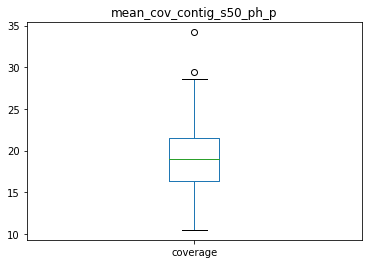

In [30]:
mean_cov_ph_contig_smaller_50_p['coverage'].plot.box()
plt.title('mean_cov_contig_s50_ph_p')
mean_s50_ph_p = mean_cov_ph_contig_smaller_50_p['coverage'].mean()
std_s50_ph_p = mean_cov_ph_contig_smaller_50_p['coverage'].std()
print("The mean overall coverage for s50 contigs of p contigs while ph mapping is %.2f and the std is %.2f" % (mean_s50_ph_p, std_s50_ph_p))

In [31]:
#think about what thresholds to pick in the long run.
threshold_up_ph_p = mean_s50_ph_p + 2*std_s50_ph_p 
threshold_down_ph_p = mean_s50_ph_p - 2*std_s50_ph_p 

#threshold_up = mean_s2000 + 2*std_s2000
#threshold_down = mean_s2000 - 2*std_s2000

In [32]:
#potnetial fully homozygous contigs
mean_cov_per_contig_ph_pwoh = mean_cov_per_contig_ph[mean_cov_per_contig_ph.index.isin(pwoh_list)]
mean_cov_per_contig_ph_pwoh[mean_cov_per_contig_ph_pwoh.coverage > threshold_up_ph_p]['coverage']

contig
pcontig_077    28.433777
pcontig_105    47.619812
Name: coverage, dtype: float64

In [33]:
mean_file_name = os.path.join(COV_OUT_PATH, '%s_mean_cov.txt' % output_genome)

In [36]:
with open(mean_file_name,'w') as outfn:
    print('mean_s50_ph_p: %f' % mean_s50_ph_p,file=outfn)
    print('std_s50_ph_p: %f' % std_s50_ph_p, file=outfn)

In [38]:
!cat {mean_file_name}

mean_s50_ph_p: 19.101026
std_s50_ph_p: 4.202900


In [39]:
ph_cov.head()

,contig,position,coverage
0,pcontig_000,1,3
1,pcontig_000,2,3
2,pcontig_000,3,3
3,pcontig_000,4,3
4,pcontig_000,5,4


In [40]:
ph_cov_smaller_50.columns

Index(['contig', 'position', 'coverage'], dtype='object')

In [ ]:
print(ph_cov[ph_cov.contig.str.startswith('pcont')].mean())
print(ph_cov[ph_cov.contig.str.startswith('pcont')].std())

In [ ]:
ph_cov_smaller_50[ph_cov_smaller_50.contig.str.startswith('pcont')].head()

In [ ]:
#potnetial fully homozygous contigs if we are not considering the presence of haplotigs. 
#some of these haplotigs may also be collapsed compared to there primary contigs.
mean_cov_per_contig_ph[mean_cov_per_contig_ph.coverage > threshold_up_ph_p]['coverage']

#### Looking a bit into the nucmer plots of these contigs for visualization
* the hcontigs_000_xxx are fairly small sequences and maybe repeats.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#now write a loop that does it all for your over the whole two dataframes
bed_p_uniqe_list = []
bed_p_homo_list = []
process_p_df_dict = {}
process_ph_df_dict = {}
for contig in mean_cov_per_contig.index.unique():
    tmp_p_df = ''
    tmp_ph_df = ''
    #now subset the two dataframes
    tmp_p_df = p_cov[p_cov['contig'] == contig]
    tmp_p_df_ph = ph_cov[ph_cov['contig'] ==  contig]
    #generarte the rolling windows
    tmp_p_df['Rolling_w1000_p'] = tmp_p_df.rolling(window=1000, min_periods=1, center=True, win_type='blackmanharris')['coverage'].mean()
    tmp_p_df_ph['Rolling_w1000_ph_p'] = tmp_p_df_ph.rolling(window=1000, min_periods=1, center=True, win_type='blackmanharris')['coverage'].mean()
    tmp_p_df['Rolling_w1000_ph_p'] = tmp_p_df_ph['Rolling_w1000_ph_p']
    process_p_df_dict[contig] = tmp_p_df
    process_ph_df_dict[contig] = tmp_ph_df
    #potentially p_unique DNA streatches are defined as p contig cov streatches, while doing p mapping, that are heterozygous coverage
    # coverage -> mean_s2000_ph_p
    # [Rolling_w1000_p < mean_s2000_ph_p + 2*std_s2000_ph_p]
    tmp_p_df_p_unique = tmp_p_df[tmp_p_df['Rolling_w1000_p'] < (mean_s50_ph_p + 2*std_s50_ph_p)]
    if len(tmp_p_df_p_unique) > 0:
        tmp_p_df_p_unique.reset_index(drop=True, inplace=True)
        #add a position +1 column by copying the position datafram 1: and adding making position+1 for the last element
        # in the dataframe equal to its own value
        tmp_p_df_p_unique['position+1']= tmp_p_df_p_unique.loc[1:, 'position'].\
        append(pd.Series(tmp_p_df_p_unique.loc[len(tmp_p_df_p_unique)-1, 'position'], index=[tmp_p_df_p_unique.index[-1]])).reset_index(drop=True)

        tmp_p_df_p_unique['position_diff+1'] = tmp_p_df_p_unique['position+1'] - tmp_p_df_p_unique['position']

        #add a position -1 column by copying the position datafram :len-2 and adding/making position-1 for the first element
        # in the dataframe equal to its own value
        position_1 = list(tmp_p_df_p_unique.loc[:len(tmp_p_df_p_unique)-2, 'position'])
        position_1.insert(0, tmp_p_df_p_unique.loc[0, 'position'])

        tmp_p_df_p_unique['position-1']= position_1

        tmp_p_df_p_unique['position_diff-1'] =  tmp_p_df_p_unique['position'] - tmp_p_df_p_unique['position-1']
        #start points of feature streatch => where previous position is unequal 1 away
        #tmp_p_df_p_unique[tmp_p_df_p_unique['position_diff-1'] != 1 ].head()

        start_pos_index = ''
        stop_pos_index = ''
        contig_name_list = ''
        p_unique_bed = ''
        #this should be good  now as it flows double check and loop around to finish this off
        start_pos_index = tmp_p_df_p_unique[tmp_p_df_p_unique['position_diff-1'] != 1 ].index
        stop_pos_index = tmp_p_df_p_unique[tmp_p_df_p_unique['position_diff+1'] != 1 ].index

        contig_name_list = [contig]*len(start_pos_index)

        start_pos = [tmp_p_df_p_unique.loc[pos, 'position'] -1 for pos in start_pos_index]
        stop_pos = [tmp_p_df_p_unique.loc[pos, 'position']  for pos in stop_pos_index]

        p_unique_bed = pd.DataFrame([contig_name_list, start_pos, stop_pos]).T
        bed_p_uniqe_list.append(p_unique_bed)
    
    #potentially p_homo DNA streatches are defined as p contig cov streatches, while doing ph mapping, that are homozygous coverage
    # coverage -> 2*mean_s2000_ph_p
    # [Rolling_w1000_p > 2*mean_s2000_ph_p - 2*std_s2000_ph_p]
    #here might be a consideration to ask for a difference in profile (covariance != 1)
    tmp_p_df_p_homo = tmp_p_df[(tmp_p_df['Rolling_w1000_ph_p'] > (2*mean_s2000_ph_p - 2*std_s2000_ph_p))]
    if len(tmp_p_df_p_homo) > 0:
        tmp_p_df_p_homo.reset_index(drop=True, inplace=True)
        #add a position +1 column by copying the position datafram 1: and adding making position+1 for the last element
        # in the dataframe equal to its own value
        tmp_p_df_p_homo['position+1']= tmp_p_df_p_homo.loc[1:, 'position'].\
        append(pd.Series(tmp_p_df_p_homo.loc[len(tmp_p_df_p_homo)-1, 'position'], index=[tmp_p_df_p_homo.index[-1]])).reset_index(drop=True)

        tmp_p_df_p_homo['position_diff+1'] = tmp_p_df_p_homo['position+1'] - tmp_p_df_p_homo['position']

        #add a position -1 column by copying the position datafram :len-2 and adding/making position-1 for the first element
        # in the dataframe equal to its own value
        position_1 = list(tmp_p_df_p_homo.loc[:len(tmp_p_df_p_homo)-2, 'position'])
        position_1.insert(0, tmp_p_df_p_homo.loc[0, 'position'])

        tmp_p_df_p_homo['position-1']= position_1

        tmp_p_df_p_homo['position_diff-1'] =  tmp_p_df_p_homo['position'] - tmp_p_df_p_homo['position-1']
        #start points of feature streatch => where previous position is unequal 1 away
        #tmp_p_df_p_homo[tmp_p_df_p_homo['position_diff-1'] != 1 ].head()

        start_pos_index = ''
        stop_pos_index = ''
        contig_name_list = ''
        p_homo_bed = ''
        #this should be good  now as it flows double check and loop around to finish this off
        start_pos_index = tmp_p_df_p_homo[tmp_p_df_p_homo['position_diff-1'] != 1 ].index
        stop_pos_index = tmp_p_df_p_homo[tmp_p_df_p_homo['position_diff+1'] != 1 ].index

        contig_name_list = [contig]*len(start_pos_index)

        start_pos = [tmp_p_df_p_homo.loc[pos, 'position'] -1 for pos in start_pos_index]
        stop_pos = [tmp_p_df_p_homo.loc[pos, 'position']  for pos in stop_pos_index]

        p_homo_bed = pd.DataFrame([contig_name_list, start_pos, stop_pos]).T
        bed_p_homo_list.append(p_homo_bed)

print('Contig %s done.' % contig)

In [ ]:
len(bed_p_uniqe_list)

In [ ]:
p_homo_bed_df = pd.concat(bed_p_homo_list).sort_values(by=[0,1])
p_unique_bed_df =  pd.concat(bed_p_uniqe_list).sort_values(by=[0,1])

In [ ]:
#p_homo_bed_df.to_csv(cov_folder+'Pst_E104_v1_ph_ctg.ph_p_homo_cov.bed', header=None, index=None, sep='\t')
#p_unique_bed_df.to_csv(cov_folder+'Pst_E104_v1_ph_ctg.p_p_het_cov.bed', header=None, index=None, sep='\t')

In [ ]:
p_homo_bed_df.to_csv(os.path.join(COV_OUT_PATH, output_genome + '_ph_ctg.ph_p_homo_cov.bed'), header=None, index = None, sep ='\t')
p_unique_bed_df.to_csv(os.path.join(COV_OUT_PATH, output_genome + '_ph_ctg.p_p_het_cov.bed'), header=None, index = None, sep ='\t')

In [ ]:
#also write out the proceessed dataframes with rolling and such
process_p_df = pd.concat(process_p_df_dict.values()).sort_values(by=['contig','position'])
process_ph_df = pd.concat(process_p_df_dict.values()).sort_values(by=['contig','position'])
process_p_df.to_csv(os.path.join(COV_OUT_PATH, input_genome + 'p_ctg.' +coverage_file_suffix.replace('.cov', '.processed.cov')), index = None, sep ='\t')
process_ph_df.to_csv(os.path.join(COV_OUT_PATH, input_genome + 'ph_ctg.'+coverage_file_suffix.replace('.cov', '.processed.cov')), index = None, sep ='\t')